In [1]:
import numpy as np
import numba as nb
import time

# Introduction 
We want to minimize the function $z = b ( 1 - e^{\frac{1}{2} w (x^2 + y^2)}) + \frac{1}{2} q (-x^3 +y)^2$.


With gradient in components:

- x component
\begin{equation}
be^{-\frac{1}{2}w(x^2+y^2)}wx - 3qx^2(-x^3+y)
\end{equation}

- y component
\begin{equation}
be^{-\frac{1}{2}w(x^2+y^2)}wy + q(-x^3+y)
\end{equation}

with parameters $w=10$ $q=\frac{1}{10}$ e $b=20$

For starting just have a look to function:

In [2]:
b = 20
q = 1/10
w = 10

#function to be minimized
def f(x, y):
    return b*(1-np.exp( - (1/2) * w * (x**2 + y**2))) + (q/2) * ( - x**3 + y)**2

#derivative w.r.t x
def fx(x, y):
    return b * np.exp(-1/2 * w * (x**2 + y**2)) * w * x - 3 * q * x**2 *(-x**3 + y)

#derivative w.r.t y
def fy(x, y):
    return b * np.exp(-1/2 * w * (x**2 + y**2)) * w * y + q *(-x**3 + y)

#gradient
def grad_f(param):
    x = param[0]
    y = param[1]
    return [fx(x,y), fy(x,y)]
    

In [3]:
#Make 3D plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import LogNorm
#from itertools import zip_longest


#Define function for plotting 

def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r"):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': 0, 'vmax': 65}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(0, 65)
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

def contour_function():
    #plot beales function
    x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z=f(x,y)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(0,0, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-3, 3))
    ax.set_ylim((-3, 3))
    
    return fig,ax

x, y = np.mgrid[-3:3:31j, -3:3:31j]
fig1,ax1=plot_surface(x,y,f(x,y))
fig4,ax4 =contour_function()
plt.show()



<Figure size 640x480 with 1 Axes>

<Figure size 1000x600 with 1 Axes>

# About initial conditions and learnign rate
We can see our function is flat in a big area of the domain, so the risk is that choosing a initial point in that area the algorithms will do not improve the solution. Let see it.

In [4]:
#Defining algorithms

def gd(grad, init, n_epochs=5000, eta=10**-4, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj


def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj


def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    return ax;

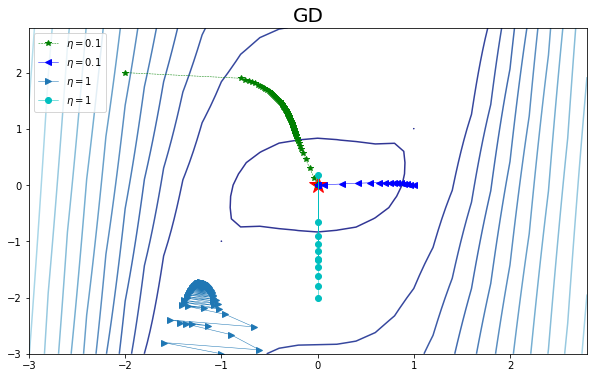

In [9]:
# Investigate effect of learning rate in GD
plt.close()
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=f(x,y)
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,2]
init2=[1,0]
init3=[-1,-3]
init4=[0,-2]
eta1=0.1
eta2=0.1
eta3=1
eta4=1
gd_1=gd(grad_f,init1, n_epochs=100, eta=eta1)
gd_2=gd(grad_f,init2, n_epochs=100, eta=eta2)
gd_3=gd(grad_f,init3, n_epochs=100, eta=eta3)
gd_4=gd(grad_f,init4, n_epochs=10, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.title('GD', size = 20)
plt.show()
#fig.savefig("GD3regimes.pdf", bbox_inches='tight')

We can see that the fact that the learning rate $\eta$ is constant is a strong limitation for our algorithm: we have to choose a learning rate for every starting point and not always it is possibile to find it. Let see now how the algorithm works adding stocasticity.

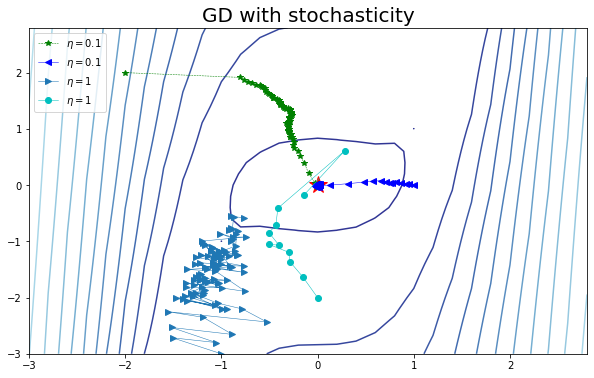

In [20]:
# Investigate effect of learning rate in GD with stochasticity
plt.close()
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=f(x,y)
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,2]
init2=[1,0]
init3=[-1,-3]
init4=[0,-2]
eta1=0.1
eta2=0.1
eta3=1
eta4=1
gd_1=gd(grad_f,init1, n_epochs=100, eta=eta1, noise_strength=0.1)
gd_2=gd(grad_f,init2, n_epochs=100, eta=eta2, noise_strength=0.1)
gd_3=gd(grad_f,init3, n_epochs=100, eta=eta3, noise_strength=0.1)
gd_4=gd(grad_f,init4, n_epochs=10, eta=eta4, noise_strength=0.1)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.title('GD with stochasticity', size = 20)
plt.show()
#fig.savefig("GD3regimes.pdf", bbox_inches='tight')

Nothing changed in general, we expect this from the fact that our function contains only one minima and we are not in a situation where we need to escape from some local minima. Let's see now how our algorithm changes adding momentum

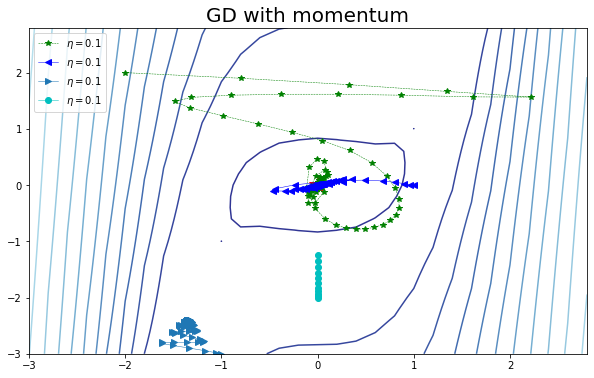

In [21]:
# Investigate effect of learning rate in GD with momentum
plt.close()
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=f(x,y)
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,2]
init2=[1,0]
init3=[-1,-3]
init4=[0,-2]
eta1=0.1
eta2=0.1
eta3=0.1
eta4=0.1
gd_1=gd_with_mom(grad_f,init1, n_epochs=100, eta=eta1)
gd_2=gd_with_mom(grad_f,init2, n_epochs=100, eta=eta2)
gd_3=gd_with_mom(grad_f,init3, n_epochs=100, eta=eta3)
gd_4=gd_with_mom(grad_f,init4, n_epochs=10, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.title('GD with momentum', size = 20)
plt.legend(loc=2)
plt.show()
#fig.savefig("GD3regimes.pdf", bbox_inches='tight')

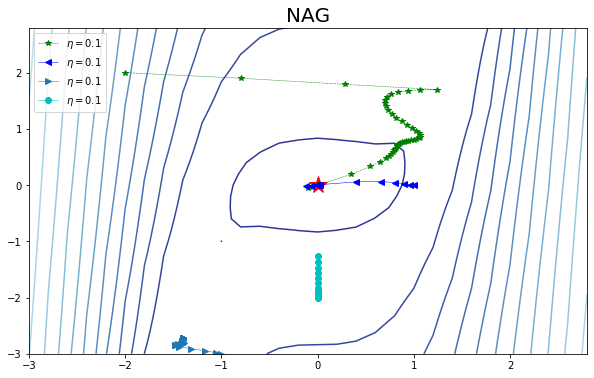

In [23]:
# Investigate effect of learning rate in NAG
plt.close()
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=f(x,y)
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,2]
init2=[1,0]
init3=[-1,-3]
init4=[0,-2]
eta1=0.1
eta2=0.1
eta3=0.1
eta4=0.1
gd_1=NAG(grad_f,init1, n_epochs=100, eta=eta1)
gd_2=NAG(grad_f,init2, n_epochs=100, eta=eta2)
gd_3=NAG(grad_f,init3, n_epochs=100, eta=eta3)
gd_4=NAG(grad_f,init4, n_epochs=10, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.title('GD with momentum', size = 20)
plt.legend(loc=2)
plt.title('NAG', size = 20)
plt.show()
#fig.savefig("GD3regimes.pdf", bbox_inches='tight')

# Statystical analysis
After choosen the best parameters for each algorithms we want to compare them in terms of accuracy and computation time.

For each algorithm we will prove various parameter values and we choose that one minimizes the mean squared distance of all found points for each condition.

Let be $Q$ the set of all initial conditions and $A: Q \rightarrow \mathbb{R}$ our algorithm function that starting from the initial point find the value for wich the function is at minima. So we define out test index $t$ as:

$t = \frac{\sum_{x \in Q} |A(x)|^2}{|Q|}$

Let start with the 'vanilla' GD:

In [5]:
#best parameters for 'vannila' gd algorithm

#defining all possibile starting point spaced by 1
x, y = np.meshgrid(np.arange(-3, 3, 1), np.arange(-3, 3, 1))
starting_points = np.array([[i,j] for i,j in zip(np.concatenate(x),np.concatenate(y))])


test = []
for noise_strength in np.linspace(0,0.1,10):
    for eta in np.logspace(-4,-1,4):
        gd_1 = []
        for init1 in starting_points:
            gd_1.append(gd(grad_f,init1, eta=eta, n_epochs=100, noise_strength=noise_strength)[-1])
    
        test.append((np.array(gd_1)**2).sum(axis = 1).mean())


/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [6]:
np.array(test).reshape((10,4))

array([[5.78792306, 4.60541886, 3.36805045,        nan],
       [5.78791767, 4.6053139 , 3.36951618,        nan],
       [5.78793651, 4.60534107, 3.36879816,        nan],
       [5.78796297, 4.60521589, 3.36455052,        nan],
       [5.78792839, 4.60554598, 3.36184841,        nan],
       [5.78792319, 4.60483484, 3.36914421,        nan],
       [5.78787285, 4.60634412, 3.37347139,        nan],
       [5.7879295 , 4.60573285, 3.35409563,        nan],
       [5.78791736, 4.6054375 , 3.35563524,        nan],
       [5.7878872 , 4.60551865, 3.37060768,        nan]])

We see the best learning rate is 0.01 (if we increase in logarithmic scale the learning rate to 0.1 the results will be unstable and the algorithm will return nan numbers). We see again stocasticity does not play a role in the algorithm. 

In [7]:
#best parameters for 'vannila' gd algorithm

#defining all possibile starting point spaced by 1
x, y = np.meshgrid(np.arange(-3, 3, 1), np.arange(-3, 3, 1))
starting_points = np.array([[i,j] for i,j in zip(np.concatenate(x),np.concatenate(y))])


test = []

for init1 in starting_points:
    gd_1 = gd(grad_f,init1, eta=10**-2)
    test.append((np.array(gd_1)**2).sum(axis = 1))

#this time we calculate the parameter t  for each iteration
test_best_gd = np.array(test).mean(axis = 0)

Repeat the same think for the gd with momentum

In [8]:
#best parameters for gd algorithm with momentum

#defining all possibile starting point spaced by 1
x, y = np.meshgrid(np.arange(-3, 3, 1), np.arange(-3, 3, 1))
starting_points = np.array([[i,j] for i,j in zip(np.concatenate(x),np.concatenate(y))])


test = []
for gamma in np.linspace(0.8,0.99,20):
    for eta in np.logspace(-4,-1,4):
        gd_1 = []
        for init1 in starting_points:
            gd_1.append(gd_with_mom(grad_f,init1, eta=eta, gamma = gamma, n_epochs=100)[-1])
    
        test.append((np.array(gd_1)**2).sum(axis = 1).mean())

/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [9]:
np.array(test).reshape((20,4))

array([[ 5.03005574,  3.79139974,  2.11365027,         nan],
       [ 5.00102813,  3.74491711,  1.96063519,         nan],
       [ 4.9700812 ,  3.7085175 ,  1.8411457 ,         nan],
       [ 4.93695299,  3.66433321,  1.77524906,         nan],
       [ 4.90132084,  3.59958176,  1.72294973,         nan],
       [ 4.86278024,  3.52700326,  1.69462588,         nan],
       [ 4.82081362,  3.47766176,  1.68774876,         nan],
       [ 4.77474298,  3.41835833,  1.73320041,         nan],
       [ 4.72365593,  3.3420377 ,  1.89382745,         nan],
       [ 4.66628805,  3.22077508,  1.90299117,         nan],
       [ 4.60083496,  3.11379238,  1.94555008,         nan],
       [ 4.52466838,  3.03506194,  1.59874921,         nan],
       [ 4.43402076,  3.00842465,  2.30207249,         nan],
       [ 4.32428595,  3.00493414,  2.15512525,         nan],
       [ 4.19309747,  2.91851006,  2.69479685,         nan],
       [ 4.04005512,  2.78362117,  4.92708372,         nan],
       [ 3.85739317,  2.

We see the best learning rate is 0.01 (if we increase in logarithmic scale the learning rate to 0.1 the results will be unstable and the algorithm will return nan numbers). We see that the best value for gamma is 0.95 and that different close values can change a lot the result of the algorithm.

In [10]:
#best parameters for gd algorithm with momentum

#defining all possibile starting point spaced by 1
x, y = np.meshgrid(np.arange(-3, 3, 1), np.arange(-3, 3, 1))
starting_points = np.array([[i,j] for i,j in zip(np.concatenate(x),np.concatenate(y))])


test = []

for init1 in starting_points:
    gd_1 = gd_with_mom(grad_f,init1, gamma = 0.95, eta=10**-2)
    test.append((np.array(gd_1)**2).sum(axis = 1))

#this time we calculate the parameter t  for each iteration
test_best_gd_with_mom = np.array(test).mean(axis = 0)

Now for NAG algorithm

In [11]:
#best parameters for NAG algorithm

#defining all possibile starting point spaced by 1
x, y = np.meshgrid(np.arange(-3, 3, 1), np.arange(-3, 3, 1))
starting_points = np.array([[i,j] for i,j in zip(np.concatenate(x),np.concatenate(y))])


test = []
for gamma in np.linspace(0.8,0.99,20):
    for eta in np.logspace(-4,-1,4):
        gd_1 = []
        for init1 in starting_points:
            gd_1.append(NAG(grad_f,init1, eta=eta, gamma = gamma, n_epochs=100)[-1])
    
        test.append((np.array(gd_1)**2).sum(axis = 1).mean())

/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [12]:
np.array(test).reshape((20,4))

array([[ 5.03650627,  3.81876317,  2.1276123 ,         nan],
       [ 5.0077402 ,  3.78491134,  2.06397225,         nan],
       [ 4.9770725 ,  3.73415512,  1.96165576,         nan],
       [ 4.94424378,  3.69363973,  1.89511325,         nan],
       [ 4.90893462,  3.64122082,  1.74847568,         nan],
       [ 4.87074453,  3.58173946,  1.70023035,         nan],
       [ 4.829161  ,  3.51502336,  1.67738829,         nan],
       [ 4.78351226,  3.46726078,  1.68339076,         nan],
       [ 4.73289333,  3.40673221,  1.97817886,         nan],
       [ 4.67604777,  3.32226655,  2.0161952 ,         nan],
       [ 4.61117932,  3.18133766,  2.20412038,         nan],
       [ 4.53567945,  3.05039576,  2.36182224,         nan],
       [ 4.44593588,  2.98431885,  2.53775354,         nan],
       [ 4.33841084,  2.9461329 ,  3.01618433,         nan],
       [ 4.21371452,  2.93523851,  4.49937003,         nan],
       [ 4.06901373,  2.82260819,  5.86336309,         nan],
       [ 3.8802993 ,  2.

We see the best learning rate is 0.01 (if we increase in logarithmic scale the learning rate to 0.1 the results will be unstable and the algorithm will return nan numbers). We see that the best value for gamma is 0.97 and that different close values can change a lot the result of the algorithm.

In [13]:
#best parameters for gd algorithm with momentum

#defining all possibile starting point spaced by 1
x, y = np.meshgrid(np.arange(-3, 3, 1), np.arange(-3, 3, 1))
starting_points = np.array([[i,j] for i,j in zip(np.concatenate(x),np.concatenate(y))])


test = []

for init1 in starting_points:
    gd_1 = NAG(grad_f,init1, gamma = 0.97, eta=10**-2)
    test.append((np.array(gd_1)**2).sum(axis = 1))

#this time we calculate the parameter t  for each iteration
test_best_nag = np.array(test).mean(axis = 0)

# Plot
Pay attention: t at y axis is not the time but the accuracy parameter we have defined

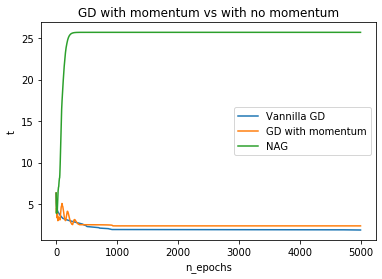

In [42]:
plt.plot(range(0,5001),test_best_gd,label = 'Vannilla GD')
plt.plot(range(0,5001), test_best_gd_with_mom,label = 'GD with momentum')
plt.plot(range(0,5001), test_best_nag,label = 'NAG')
plt.xlabel('n_epochs')
plt.ylabel('t')
#plt.xscale('log')
plt.title('GD with momentum vs with no momentum')
plt.legend()
plt.show()

# Computation time
Let compare the computation time of the solution:

In [115]:
%%timeit
#vanilla gd
for init1 in starting_points:
    gd(grad_f,init1, eta=10**-2)

5.5 s ± 759 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [116]:
%%timeit
#gd with momentum
for init1 in starting_points:
    gd_with_mom(grad_f,init1, gamma = 0.95, eta=10**-2)

4.99 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
